In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [ ]:
df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['date'])
df.head()

C:\Users\seife\AppData\Local\Temp\ipykernel_20612\1479078951.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['date'])


,date,store_nbr,family,sales,onpromotion,holiday_type,locale,transferred,dcoilwtico,city,...,quarter,day_of_week,is_crisis,sales_lag_7,rolling_mean_7,is_weekend,is_holiday,promo_last_7_days,days_to_holiday,promotion_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,False,93.14,Quito,...,1,Tuesday,0,0.0,0.0,0,1,0.0,0,Not On Promotion
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,False,93.14,Quito,...,1,Tuesday,0,0.0,0.0,0,1,0.0,0,Not On Promotion
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,False,93.14,Quito,...,1,Tuesday,0,0.0,0.0,0,1,0.0,0,Not On Promotion
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,False,93.14,Quito,...,1,Tuesday,0,0.0,0.0,0,1,0.0,0,Not On Promotion
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,False,93.14,Quito,...,1,Tuesday,0,0.0,0.0,0,1,0.0,0,Not On Promotion


In [ ]:
# subset = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')].copy()
# subset = subset.sort_values('date')

In [ ]:
feature_cols = [
    'onpromotion', 'transactions', 'dcoilwtico',
    'sales_lag_7', 'rolling_mean_7',
    'is_holiday', 'is_weekend', 'promo_last_7_days',
    'days_to_holiday', 'year', 'month', 'week', 'day_of_week'
]

target_col = 'sales'

In [ ]:
categorical_cols = [
    'holiday_type', 'locale', 'transferred', 'city', 'state',
    'store_type', 'promotion_status', 'day_of_week'
]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [ ]:
if df.isna().sum().sum() > 0:
    subset = df.dropna(subset=feature_cols + [target_col])

In [ ]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols + [target_col]])

In [ ]:
X_scaled = scaled_features[:, :-1]
y_scaled = scaled_features[:, -1]

In [ ]:
def create_sequences(X, y, window_size=14):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=14)

In [ ]:
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   
    restore_best_weights=True
)

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19968     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20033 (78.25 KB)
Trainable params: 20033 (78.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/20
76359/76359 [==============================] - 332s 4ms/step - loss: 5.6496e-05 - val_loss: 3.4823e-05
Epoch 2/20
58274/76359 [=====================>........] - ETA: 1:13 - loss: 1.7951e-05

KeyboardInterrupt: 

In [ ]:
y_pred_scaled = model.predict(X_test)

# Inverse scale predictions and ground truth
y_true = y_test.reshape(-1, 1)
y_pred = y_pred_scaled.reshape(-1, 1)


11/11 [==============================] - 0s 2ms/step


In [ ]:
# Rebuild dummy scaler to invert only sales
dummy_df = pd.DataFrame(np.zeros((len(y_true), len(feature_cols) + 1)), columns=feature_cols + [target_col])
dummy_df[target_col] = y_true.ravel()
y_true_inv = scaler.inverse_transform(dummy_df)[:, -1]

dummy_df[target_col] = y_pred.ravel()
y_pred_inv = scaler.inverse_transform(dummy_df)[:, -1]

In [ ]:
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)

print(f'LSTM Model Evaluation \nMSE: {mse:.2f} \nRMSE: {rmse:.2f} \nR2: {r2:.2f}')

LSTM Model Evaluation 
MSE: 516986.92 
RMSE: 719.02 
R2: 0.27


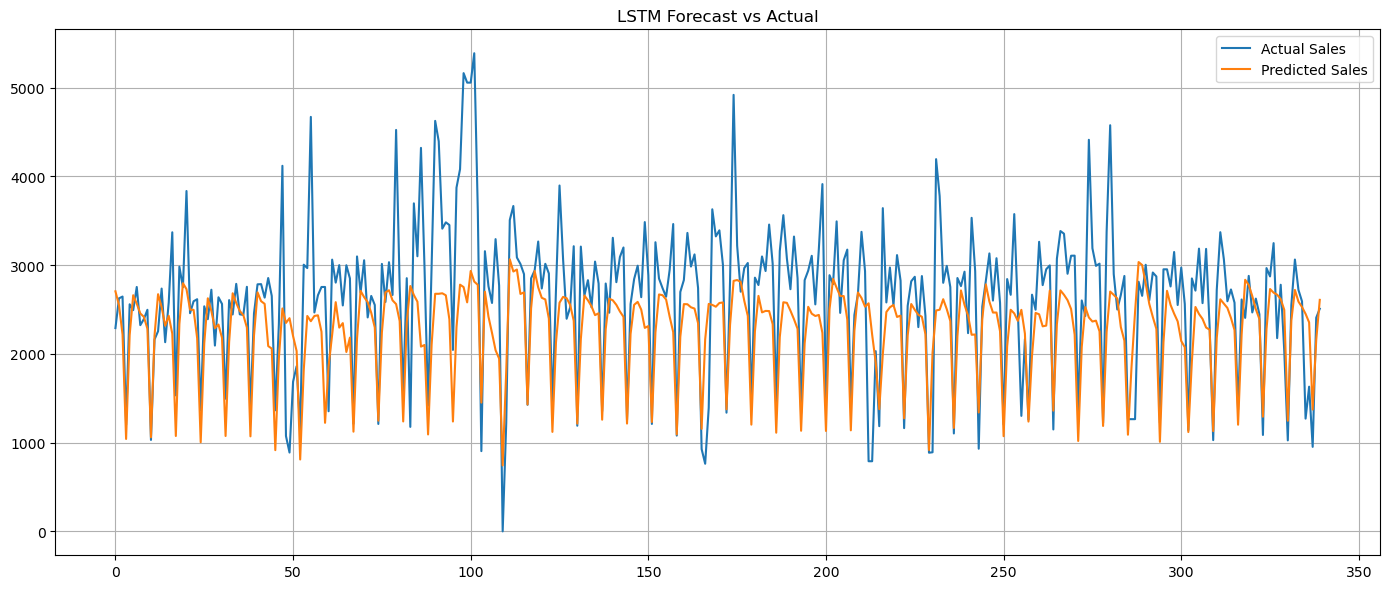

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_true_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()